In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

class ForecastGrapper:
    def __init__(self, url="https://kursprognose.com/", company="nvidia"):
        self.url = url
        self.company = company
        self._update_full_url()
        self.daily_forecast = None
        self.monthly_forecast = None
        self.combined_df = None  # Added property to store the combined DataFrame

    def _update_full_url(self):
        self.full_url = f"{self.url}{self.company}"
    
    def set_company(self, company: str):
        self.company = company
        self._update_full_url()
    
    def grap_forecast(self):
        tables = pd.read_html(self.full_url)
        
        if len(tables) >= 2:
            self.daily_forecast = tables[0]
            self.monthly_forecast = tables[1]
        else:
            raise ValueError("Not enough tables found on the webpage.")
    
    def save_forecast(self):
        if self.daily_forecast is None or self.monthly_forecast is None:
            raise ValueError("Forecast data not available. Run grap_forecast() first.")
        
        # remove year rows from monthly forecast & rmove the first row (label) from both
        mask = pd.to_numeric(self.monthly_forecast[0], errors='coerce').isna()
        monthly_forecast_filtered = self.monthly_forecast[mask]
        monthly_forecast_filtered = monthly_forecast_filtered.iloc[1+2:] # remove first two month as they are included in daily forecast
        daily_forecast_filtered = self.daily_forecast.iloc[1:]
        date_list=self._convert_date(daily_forecast_filtered[0],monthly_forecast_filtered[0])

        tmp = pd.concat([daily_forecast_filtered[3], monthly_forecast_filtered[2]], ignore_index=True)
        forecast_list = tmp.astype("Float32").tolist()

        # split the range information into two columns
        split_values = monthly_forecast_filtered[1].str.split("-", expand=True)
        low_values = split_values[0].astype(int).to_numpy()
        high_values = split_values[1].astype(int).to_numpy()

        low_values_combined = np.concatenate([pd.to_numeric(daily_forecast_filtered[2]),low_values])
        high_values_combined = np.concatenate([pd.to_numeric(daily_forecast_filtered[4]),high_values])

        combined_data_dict = {'date':date_list, 'forecast':forecast_list, 'low':low_values_combined, 'high':high_values_combined}
        combined_df = pd.DataFrame(combined_data_dict)

        current_date = datetime.now().strftime("%Y%m%d")
        filename = f"{current_date}_{self.company}_forecast.csv"
        combined_df.to_csv(filename, index=False)
        print(f"Forecast data saved to {filename}")
        self.combined_df = pd.DataFrame(combined_data_dict)

        # Save the DataFrame to a CSV file
        self.combined_df.to_csv(filename, index=False)
        print(f"Forecast data saved to {filename}")

    def get_current_stock_price(self):
        ticker_symbol = self._company_to_ticker_mapping()[self.company]
        ticker_data = yf.Ticker(ticker_symbol)  
        current_price_usd = ticker_data.history(period='1d')['Close'].iloc[0]

        # EUR/USD-Wechselkurs-Ticker
        #currency_ticker = "EURUSD=X"
        #exchange_rate = yf.Ticker(currency_ticker)
        #eur_to_usd = exchange_rate.history(period="1d")["Close"].iloc[0]
        # convert to USD
        #current_price_usd = current_price_eur * eur_to_usd
        print(f"Current stock price of {self.company} is {current_price_usd} USD")
        return current_price_usd

    def plot_forecast(self,range=None):
        if self.combined_df is None:
            raise ValueError("Forecast data not available. Run save_forecast() first.")
        
        current_stock_price = self.get_current_stock_price()
        # Plotting using the combined_df saved as a class property
        forecast_list = self.combined_df['forecast']
        low_values_combined = self.combined_df['low']
        high_values_combined = self.combined_df['high']
        date = self.combined_df['date']
        # Plotting
        plt.figure(figsize=(10, 6))
        
        # Plot the forecast line
        plt.plot(date,forecast_list, label='Forecast', color='blue', lw=2)
        plt.plot(date[0], current_stock_price, 'ro', label='Current Price')
        
        # Plot the confidence interval (shaded area between low and high)
        plt.fill_between(date,low_values_combined, high_values_combined, color='blue', alpha=0.3, label='Confidence Interval')

        # Add labels and title
        plt.xlabel('Date')
        plt.ylabel('Price / USD')
        plt.title(f'{self.company} Forecast')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.title(f'{self.company} Forecast')
        if range is not None:
            plt.xlim(date[0], date[range])
        
        # Show plot
        plt.tight_layout()
        plt.show()
       
    def _convert_date(self, days_col,month_cols):
        
        current_year = datetime.now().year
        dates = []
        prev_month = None
        dates, current_year, prev_month = self._convert_date_column(days_col,dates,current_year,prev_month)

        replace_dict = self._month_to_date_conv()
        month_cols = month_cols.replace(replace_dict)
        dates, current_year, prev_month = self._convert_date_column(month_cols,dates,current_year,prev_month)
        
        return dates
    
    @staticmethod
    def _convert_date_column(date_col,dates,current_year,prev_month=None):
        for date in date_col:
            day_month = date.split(".")
            if prev_month is None:
                prev_month = int(day_month[1])
            else:
                if prev_month > int(day_month[1]):
                    current_year += 1
                prev_month = int(day_month[1])
            dates.append(pd.Timestamp(year=current_year, month=int(day_month[1]), day=int(day_month[0])))
        return dates, current_year, prev_month

    @staticmethod
    def _month_to_date_conv():
        return {
                "Januar": "01.01",
                "Februar": "01.02",
                "März": "01.03",
                "April": "01.04",
                "Mai": "01.05",
                "Juni": "01.06",
                "Juli": "01.07",
                "August": "01.08",
                "September": "01.09",
                "Oktober": "01.10",
                "November": "01.11",
                "Dezember": "01.12"
            }
    @staticmethod
    def _company_to_ticker_mapping():
        return {
            "nvidia": "NVDA",
            "apple": "AAPL",
            "amazon": "AMZN",
            "tesla": "TSLA",
            "microsoft": "MSFT",
            "rhm-aktie": "RHM.DE",
            "netflix":"NFLX"
        }

Forecast data saved to 20250329_nvidia_forecast.csv
Forecast data saved to 20250329_nvidia_forecast.csv
Current stock price of nvidia is 109.66999816894531 USD


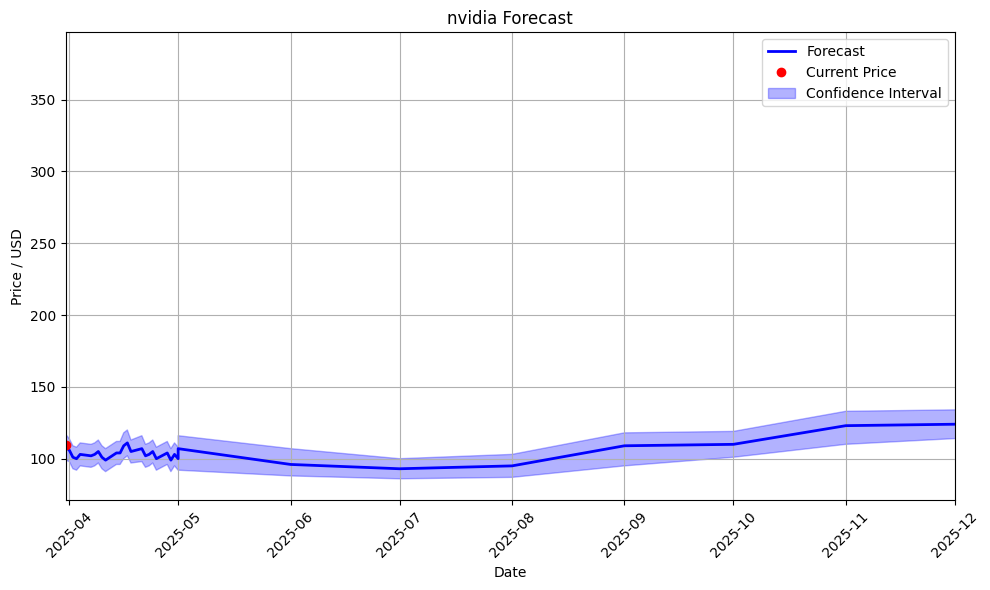

In [3]:
fcg = ForecastGrapper()
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250329_rhm-aktie_forecast.csv
Forecast data saved to 20250329_rhm-aktie_forecast.csv
Current stock price of rhm-aktie is 1310.0 USD


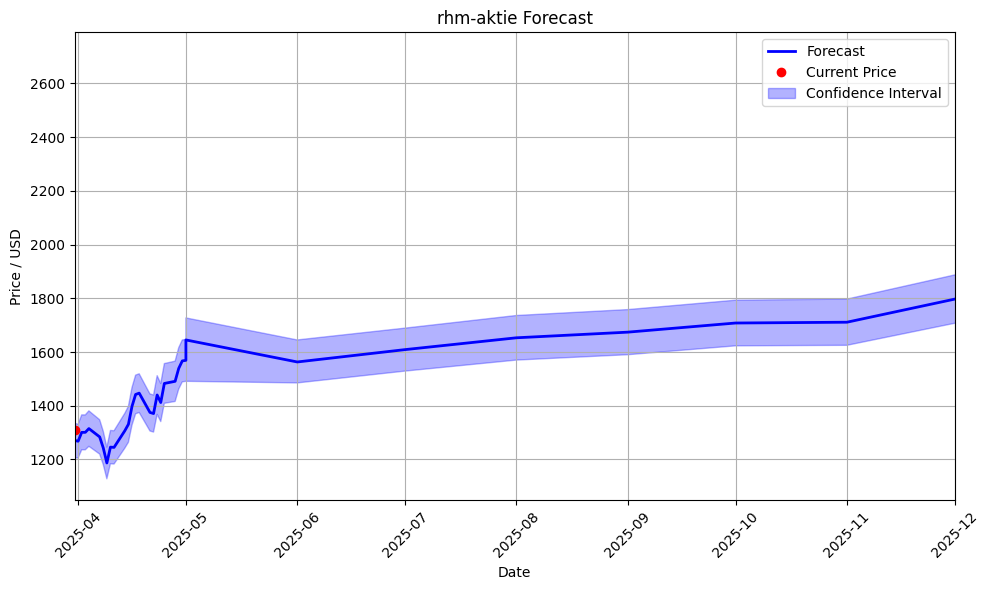

In [4]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250329_tesla_forecast.csv
Forecast data saved to 20250329_tesla_forecast.csv
Current stock price of tesla is 263.54998779296875 USD


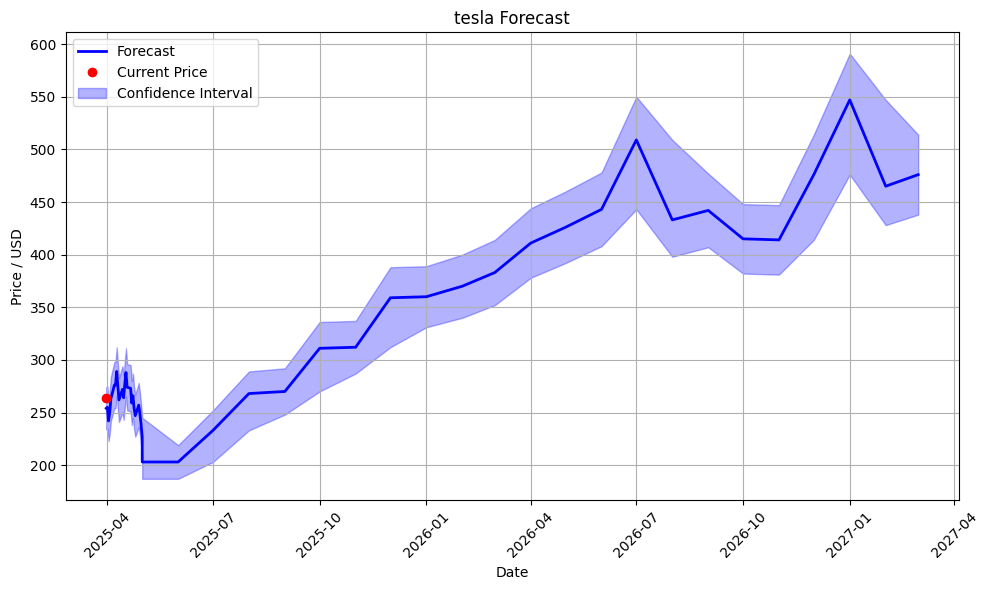

In [5]:
fcg.set_company("tesla")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250329_netflix_forecast.csv
Forecast data saved to 20250329_netflix_forecast.csv
Current stock price of netflix is 933.8499755859375 USD


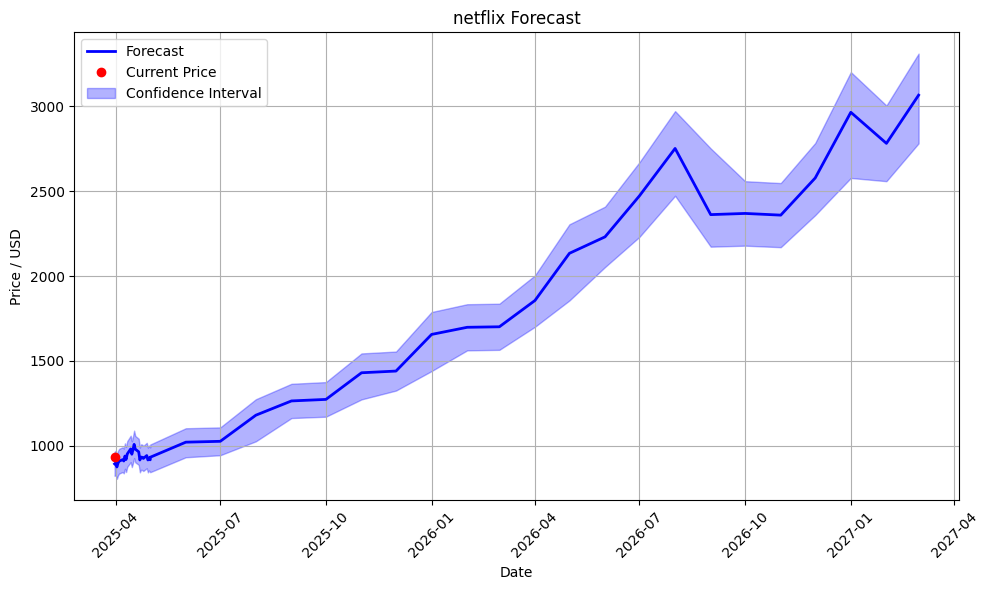

In [6]:
fcg.set_company("netflix")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()